# Basics of machine learning with text data: bag-of-words for linear regression



The `wget` command below should work on Linux or Mac OS (if wget is installed). Otherwise, just download the data and run the notebook from wherever you downloaded the data to.

In [2]:
# this should work on Mac (if wget is installed) or Unix
!wget -O - --no-check-certificate https://files.pushshift.io/twitter/US_PoliticalTweets.tar.gz | tar -xz

--2021-10-23 22:52:00--  https://files.pushshift.io/twitter/US_PoliticalTweets.tar.gz
Resolving files.pushshift.io (files.pushshift.io)... 104.21.55.251, 172.67.174.211, 2606:4700:3032::ac43:aed3, ...
Connecting to files.pushshift.io (files.pushshift.io)|104.21.55.251|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 240797053 (230M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 229.64M  13.1MB/s    in 18s     

2021-10-23 22:52:18 (13.0 MB/s) - written to stdout [240797053/240797053]



In [1]:
!du -h *.json

1.6G	tweets.json
916K	users.json


In [2]:
# numpy and pandas for data-wrangling
import numpy as np
import pandas as pd
# matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
import json
with open('users.json', 'r') as infile:
    users = [json.loads(line) for line in infile.readlines()]
user_df = pd.DataFrame(users)
len(user_df)

548

In [4]:
user_df.sort_values(by='followers_count', ascending=False)[['screen_name', 'followers_count']].head(10)

,screen_name,followers_count
150,realDonaldTrump,31712585
147,POTUS,18545354
509,SenSanders,5072538
31,CoryBooker,3094413
118,marcorubio,2554822
520,SenWarren,2412087
501,SenJohnMcCain,2274034
131,NancyPelosi,1126205
90,JerryBrownGov,1119275
515,SenTedCruz,960413


In [5]:
!head -n 1 tweets.json | python -m json.tool

{
    "contributors": null,
    "coordinates": null,
    "created_at": 1217870931,
    "display_text_range": [
        0,
        74
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "urls": [],
        "user_mentions": []
    },
    "favorite_count": 0,
    "favorited": false,
    "geo": null,
    "id": 877418565,
    "id_str": "877418565",
    "in_reply_to_screen_name": null,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "is_quote_status": false,
    "lang": "en",
    "place": null,
    "retweet_count": 0,
    "retweeted": false,
    "screen_name": "JohnBoozman",
    "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
    "text": "On a conference call about a weekend trip to Iraq to visit Arkansas troops",
    "truncated": false,
    "user_id": 5558312
}


Documentation for keys in the tweet data is provided by Twitter. [See here.](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) It looks like we only care about the actual tweet text (`text`), the screen name of the tweeting user (`screen_name`), and the number of likes (`favorite_count`).

In [6]:
with open('tweets.json', 'r') as infile:
    tweets = []
    for line in infile:
        tweet = json.loads(line)
        tweet = {
            'screen_name': tweet['screen_name'],
            'favorite_count': tweet['favorite_count'],
            'text': tweet['text'],
        }
        tweets.append(tweet)
tweet_df = pd.DataFrame(tweets)
len(tweet_df)

1243370

In [7]:
counts = tweet_df.screen_name.value_counts()
counts.head(10)

RepDonBeyer        3258
SenatorDurbin      3252
MassGovernor       3250
GovMattBevin       3250
GrahamBlog         3249
SenRonJohnson      3249
SenTomCotton       3249
onetoughnerd       3249
RepScottPeters     3248
GovMalloyOffice    3247
Name: screen_name, dtype: int64

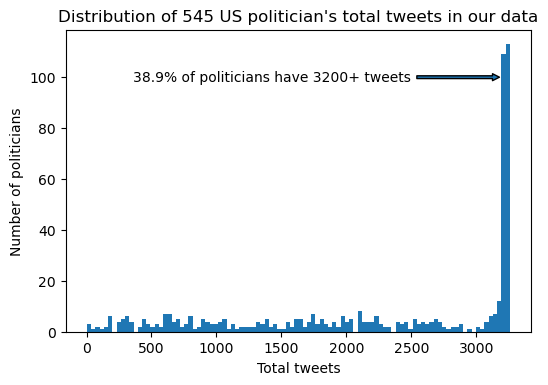

In [8]:
plt.hist(counts, bins=100)
plt.title(f"Distribution of {len(counts)} US politician's total tweets in our data")
plt.xlabel("Total tweets")
plt.ylabel("Number of politicians")
plt.annotate(f'{sum(counts >= 3200) / len(counts):.1%} of politicians have 3200+ tweets', (3200, 100), xytext=(2500, 100), arrowprops={'arrowstyle': 'simple'}, va='center', ha='right')
plt.show()

In [9]:
def simple_tokenize(tweet_text):
    tokens = tweet_text.split()
    return tokens
    
tweet_df['tokens'] = tweet_df.text.map(simple_tokenize)

In [10]:
tweet_df['token_count'] = tweet_df.tokens.map(len)
tweet_df.token_count.max()

42

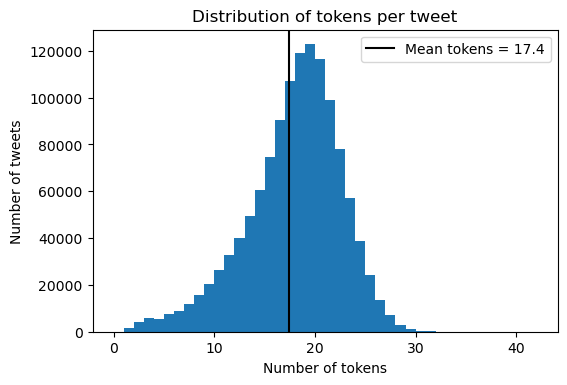

In [11]:
plt.hist(tweet_df.token_count, bins=range(0, tweet_df.token_count.max() + 1))
plt.title("Distribution of tokens per tweet")
plt.xlabel("Number of tokens")
plt.ylabel("Number of tweets")
mean_token_count = tweet_df.token_count.mean()
plt.axvline(mean_token_count, color='black', label=f'Mean tokens = {mean_token_count:.1f}')
plt.legend()
plt.show()

In [12]:
tweet_df[tweet_df.token_count == tweet_df.token_count.max()].text.iloc[0]

'.@SciCmteDems @MichaelEMann @RepBonamici @capitalweather @HouseScience @BadAstronomer @NaomiOreskes @ClimateFdbk @VariabilityBlog @RasmusBenestad @TimOsbornClim @AGW_Prof @CubaRaglanGuy @DeformedEarth @epispheric @mzelinka @hausfath @ChrisJMerchant @LovejoyShaun @PeterGleick And I want to invite anyone who wants to help defend science to fact-check future @HouseScience hearings at the hashtag #FactCheckSST 13/13'

Maybe this is making us reconsider our tokenization strategy.  

In [69]:
import re

def normalize_token(token):
    # Lowercase and remove all non-alphanumeric characters
    return re.sub("[^0-9a-zA-Z]+", "", token).lower()

def better_tokenize(tweet_text):
    tokens = tweet_text.split()
    tokens_to_keep = []
    for token in tokens:
        if token.startswith('@'):
            token = '@'
        elif token.startswith('https://'):
            token = '/link'
        else:
            token = normalize_token(token)
            if token == '':
                continue
        tokens_to_keep.append(token)
#    tokens = [normalize_token(token) for token in tokens if not token.startswith('@')]
    return tokens_to_keep
    
tweet_df['tokens'] = tweet_df.text.map(better_tokenize)
tweet_df['token_count'] = tweet_df.tokens.map(len)
tweet_df.token_count.max()

42

Here are the longest tweets with the new tokenization strategy.

In [73]:
# here are the longest tweets with the
for row in tweet_df.sort_values(by='token_count', ascending=False).head(5).itertuples():
    print(f"{row.screen_name} ({row.token_count} tokens):\n{row.text}\n{row.tokens}\n")

RepDonBeyer (42 tokens):
.@SciCmteDems @MichaelEMann @RepBonamici @capitalweather @HouseScience @BadAstronomer @NaomiOreskes @ClimateFdbk @VariabilityBlog @RasmusBenestad @TimOsbornClim @AGW_Prof @CubaRaglanGuy @DeformedEarth @epispheric @mzelinka @hausfath @ChrisJMerchant @LovejoyShaun @PeterGleick And I want to invite anyone who wants to help defend science to fact-check future @HouseScience hearings at the hashtag #FactCheckSST 13/13
['scicmtedems', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', 'and', 'i', 'want', 'to', 'invite', 'anyone', 'who', 'wants', 'to', 'help', 'defend', 'science', 'to', 'factcheck', 'future', '@', 'hearings', 'at', 'the', 'hashtag', 'factchecksst', '1313']

GovernorTomWolf (38 tokens):
.@RepLouBarletta @CongBoyle @RepBrady @RepCartwright @RepRyanCostello @RepCharlieDent @USRepMikeDoyle @RepDwightEvans @RepFitzpatrick @MikeKellyPA @RepTomMarino @RepMeehan @RepTimMurphy @RepScottPerry @KeithRothfus @RepBillShus

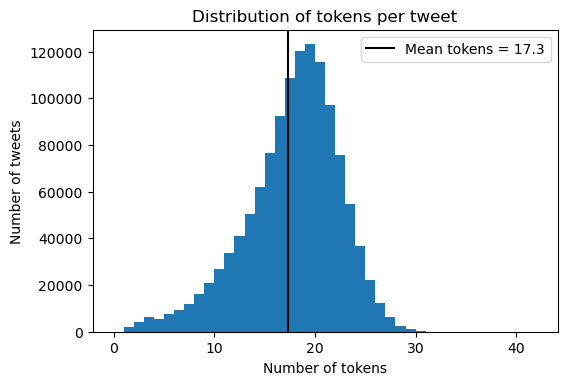

In [74]:
plt.hist(tweet_df.token_count, bins=range(0, tweet_df.token_count.max() + 1))
plt.title("Distribution of tokens per tweet")
plt.xlabel("Number of tokens")
plt.ylabel("Number of tweets")
mean_token_count = tweet_df.token_count.mean()
plt.axvline(mean_token_count, color='black', label=f'Mean tokens = {mean_token_count:.1f}')
plt.legend()
plt.show()

In [75]:
from collections import Counter

token_counter = Counter()
for tokens in tweet_df.tokens:
    token_counter.update(tokens)
token_counter.most_common(10)

[('@', 989015),
 ('to', 779941),
 ('the', 735312),
 ('/link', 499420),
 ('of', 367153),
 ('in', 364656),
 ('for', 338542),
 ('a', 279474),
 ('rt', 267394),
 ('on', 266927)]

### Zipf's Law

Word (or token) usage follows a predictable distribution.

If 'to' is the most common word and appears at frequency $f_{\text{max}}$, then the frequency of the second most common word is approximately $f = \frac{1}{2} f_{\text{max}}$, the frequency of the third most common word is approximately $f = \frac{1}{3} f_{\text{max}}$, etc.

In general terms, the $k$th most common word appears with frequency $f = \frac{1}{k} f_{\text{max}}$.

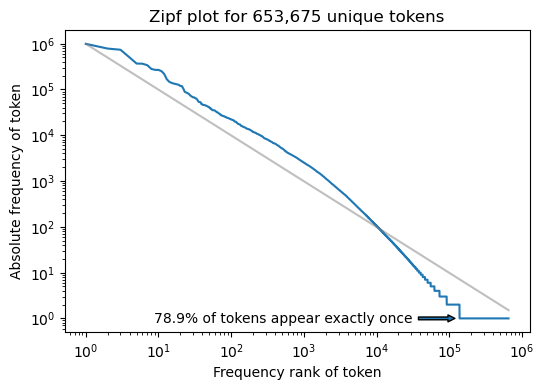

In [76]:
# plot word rank vs word count
token_counts = np.array([count for token, count in token_counter.most_common()])
plt.loglog(range(1, len(token_counts)+1), token_counts)

# compute and plot the counts if the true distribution was Zipfian
largest_count = token_counts[0]
true_zipf = [(1, largest_count)]
for i in np.geomspace(1, len(token_counts), endpoint=True, num=25):
    rank = int(i) + 1
    true_zipf.append((rank, largest_count * 1/rank))
xs, ys = zip(*true_zipf)
plt.plot(xs, ys, color='gray', linestyle='-', alpha=0.5)
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.title(f"Zipf plot for {len(token_counts):,} unique tokens")
# annotate the hapax legomena 
plt.annotate(f"{sum(token_counts == 1) / len(token_counts):.1%} of tokens appear exactly once",
             xy=(len(token_counts) * 0.2, 1), xytext=(10**4.5, 1), arrowprops={'arrowstyle': 'simple'}, va='center', ha='right')
plt.show()

We call tokens that appear exactly once [_hapax legomena_](https://en.wikipedia.org/wiki/Hapax_legomenon) or sometimes just _hapaxes_.

80% is higher than we would expect for more general English text: we would see that number drop if we did further normalization (e.g. so we don't count 'country.'/'country', '#Thanksgiving'/'Thanksgiving', or 'Great'/'great' as different tokens). 

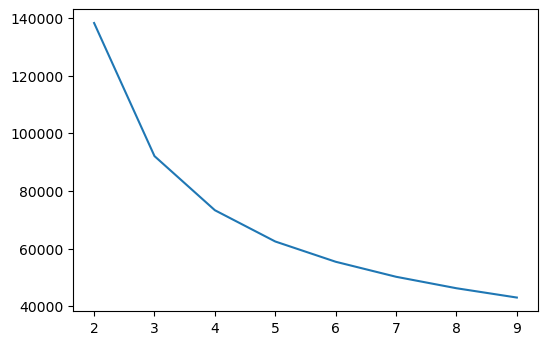

In [77]:
# how large will our vocabulary be at different absolute token frequency cut-offs?
xs = []
ys =[]
for i in range(2, 10):
    xs.append(i)
    ys.append(np.sum(token_counts >= i))
    
plt.plot(xs, ys)
plt.show()

Note: vocabulary size is an empirical question, and should be chosen based on desired purpose. If the goal is to maximize predictive model performance, than vocab size should be treated as a hyperparameter during model selection.

We'll set our vocab size to 30,000, which is a reasonable and fairly common value.

In [78]:
V = 30000
token_index_map = {}
index = 0
for token, count in token_counter.most_common(V):
    token_index_map[token] = index
    index += 1

In [79]:
# to check our work, we need to map back from indices to the actual token text
index_token_map = {index: token for token, index in token_index_map.items()}

In [81]:
token_index_map['iraq']

1437

In [83]:
index_token_map[1437]

'iraq'

In [84]:
# the very last word in our vocabulary
index_token_map[29999]

'demos'

Building the [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix). ("Term" just means "token".)

In [85]:
n_train = 100000
n_test = 100000
sdf = tweet_df.sample(n=n_train + n_test)
len(sdf)

200000

In [86]:
from tqdm import tqdm
X = np.zeros((len(sdf), V + 1), dtype='float32')
for row_ind, tokens in tqdm(enumerate(sdf.tokens), total=len(sdf)):
    for token in tokens:
        if token not in token_index_map:
            # this is a word not in the vocabulary!
            continue
        column_ind = token_index_map[token]
        X[row_ind, column_ind] += 1
    # the intercept column is always 1
    X[row_ind, V] = 1
X.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:26<00:00, 7450.88it/s]


(200000, 30001)

In [88]:
row_ind = 0
print(sdf.iloc[row_ind].text + "\n")

for column_ind in np.argwhere(X[row_ind,:]).ravel():
    if column_ind == V:
        print(f"ind= {column_ind:>5}  n= {X[row_ind,column_ind]:.0f}  intercept")
    else:
        token = index_token_map[column_ind]
        print(f"ind= {column_ind:>5}  n= {X[row_ind,column_ind]:.0f}  token= {token}")


RT @JudgeJohnCarter: Enjoyed @RepBillFlores #prayer for a #StrongerAmerica #rpt16 #RPT2016 #UniteToWin2016 https://t.co/KZd9vvCEx2

ind=     0  n= 2  token= @
ind=     3  n= 1  token= /link
ind=     6  n= 1  token= for
ind=     7  n= 1  token= a
ind=     8  n= 1  token= rt
ind=   260  n= 1  token= enjoyed
ind=  1752  n= 1  token= prayer
ind=  6278  n= 1  token= strongeramerica
ind= 30000  n= 1  intercept


In [89]:
y = np.array(sdf.favorite_count, dtype='float32')
y.shape

(200000,)

In [90]:
X.shape

(200000, 30001)

In [91]:
X.nbytes / 1024 / 1024 / 1024  # 22 GB!!!

22.352486848831177

In [92]:
X_train = X[:n_train]
X_test = X[n_train:]
X_train.shape, X_test.shape

((100000, 30001), (100000, 30001))

In [93]:
y_train = y[:n_train]
y_test = y[n_train:]
y_train.shape, y_test.shape

((100000,), (100000,))

In [32]:
import sklearn.linear_model
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
model.coef_.shape

(30001,)

In [37]:
A = np.matmul(X_train.T, X_train)
A.shape

(30001, 30001)

In [39]:
A_inv = np.linalg.pinv(A)

init_dgesdd failed init


In [46]:
y_train = y_train.reshape((-1, 1))
y_train.shape

(100000, 1)

In [47]:
w = A_inv.dot(X_train.T).dot(y_train)
w.shape

(30001, 1)

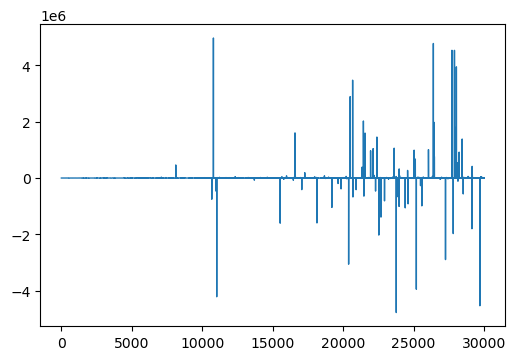

In [37]:
#random_inds = np.random.permutation(np.arange(len(w)))
w = model.coef_
#plt.bar(range(len(w)), w, width=1)
plt.plot(range(len(w)), w, linewidth=1)
plt.show()

In [94]:
import sklearn.linear_model
model = sklearn.linear_model.ElasticNet(fit_intercept=False)
model.fit(X_train, y_train)
model.coef_.shape

(30001,)

In [95]:
# non-zero coefficients
np.sum(~np.isclose(model.coef_[:-1], 0))

907

In [113]:
w = model.coef_
weights = []
for i, weight in enumerate(w[:-1]):
    token = index_token_map[i]
    if weight != 0:
        weights.append({
            'token': token,
            'token_count': token_counter[token],
            'weight': weight,
            'abs_weight': np.abs(weight),
        })
        
#w = w[:-1]  # remove the intercept
#w.sort()
#w = w[~np.isclose(w, 0)]
weight_df = pd.DataFrame(weights)
len(weight_df)

907

In [114]:
weight_df.sort_values(by='weight', ascending=False).head(10)

,token,token_count,weight,abs_weight
2,the,735312,53.594498,53.594498
11,is,167350,51.791077,51.791077
9,and,250558,49.726624,49.726624
23,will,83496,43.519436,43.519436
18,we,118824,31.727180,31.727180
3,/link,499420,30.795961,30.795961
15,i,131962,30.680773,30.680773
6,a,279474,29.631046,29.631046
74,they,25131,24.120056,24.120056
31,have,63147,23.424078,23.424078


In [115]:
weight_df.sort_values(by='weight', ascending=True).head(10)

,token,token_count,weight,abs_weight
0,@,989015,-33.517887,33.517887
7,rt,267394,-31.069569,31.069569
20,today,103775,-10.088549,10.088549
42,thanks,44461,-6.418712,6.418712
37,bill,47668,-6.330957,6.330957
62,proud,29286,-4.065671,4.065671
38,house,47323,-3.883245,3.883245
21,from,88361,-3.640216,3.640216
51,act,35523,-3.527932,3.527932
93,office,21905,-3.497819,3.497819


In [118]:
weight_df[weight_df.token_count <= weight_df.token_count.quantile(0.99)].sort_values(by='abs_weight', ascending=True).head(10)

,token,token_count,weight,abs_weight
678,holdthefloor,613,0.001167,0.001167
418,visited,3838,-0.002096,0.002096
317,latest,6193,-0.003757,0.003757
461,ahead,2850,0.006283,0.006283
689,j,576,0.006338,0.006338
568,society,1473,0.006451,0.006451
895,g7,25,0.007846,0.007846
415,allow,3868,0.008158,0.008158
217,action,9263,-0.009150,0.009150
657,guy,800,0.010701,0.010701


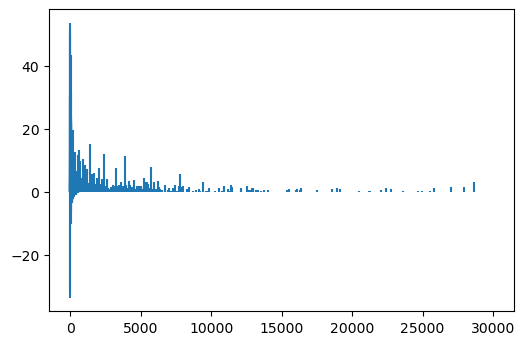

In [100]:
#random_inds = np.random.permutation(np.arange(len(w)))
w = model.coef_[:-1]
#plt.bar(range(len(w)), w, width=1)
plt.vlines(range(len(w)), np.minimum(w, 0), np.maximum(w, 0))
#plt.plot(range(len(w)), w, linewidth=1)
plt.show()

In [119]:
y_pred = model.predict(X_test)
y_pred.shape

(100000,)

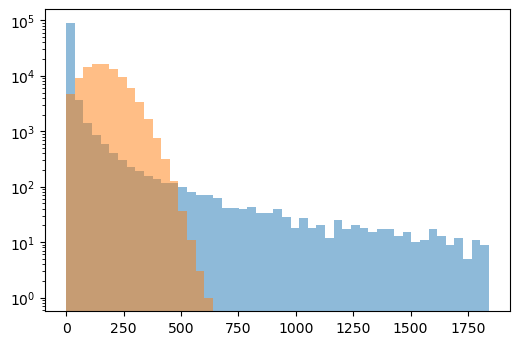

In [127]:
bins = np.linspace(0, np.quantile(y_test, 0.99))
plt.hist(y_test, bins=bins, alpha=0.5, log=True)
plt.hist(y_pred, bins=bins, alpha=0.5, log=True)
plt.show()

This is an indication that our model may not be expressive enough to capture more complex associations between tweet content and number of likes.

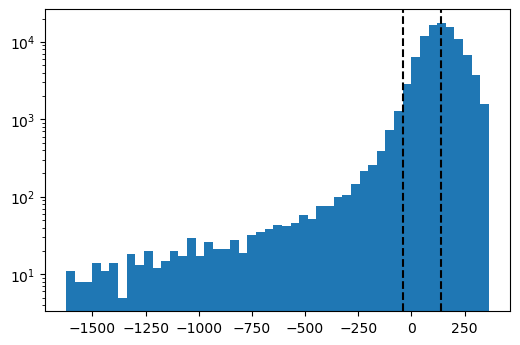

137.41283

In [142]:
errors = y_pred - y_test
plt.hist(errors, log=True, bins=np.linspace(np.quantile(errors, 0.01), np.quantile(errors, 0.99)))
plt.axvline(np.mean(errors), linestyle='--', color='black')
plt.axvline(np.median(errors), linestyle='--', color='black')
plt.show()
np.median(errors)

If we just use the mean or the median, we'd misunderstand our model's behavior.

 - More than half of tweets we overestimate the number of likes they'll receive.
 - ... but, we sometimes are horribly wrong (i.e. bad at predicting breakout successes).

In [136]:
np.sum(np.abs(errors) <= 100) / len(errors)

0.30653

In [138]:
np.sum(errors < 0) / len(errors)

0.08007